Please upload your featured Voltas dataset CSV file.


Saving voltas_featured.csv to voltas_featured.csv
Uploaded file: voltas_featured.csv

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   product_id                    500 non-null    object 
 1   product_category              500 non-null    object 
 2   sub_type                      500 non-null    object 
 3   model_name                    500 non-null    object 
 4   capacity_tons                 500 non-null    float64
 5   capacity_liters               500 non-null    float64
 6   capacity_kg                   500 non-null    float64
 7   capacity_place_settings       500 non-null    float64
 8   technology                    500 non-null    object 
 9   feature_1                     500 non-null    object 
 10  energy_rating_stars           500 non-null    float64
 11  color              

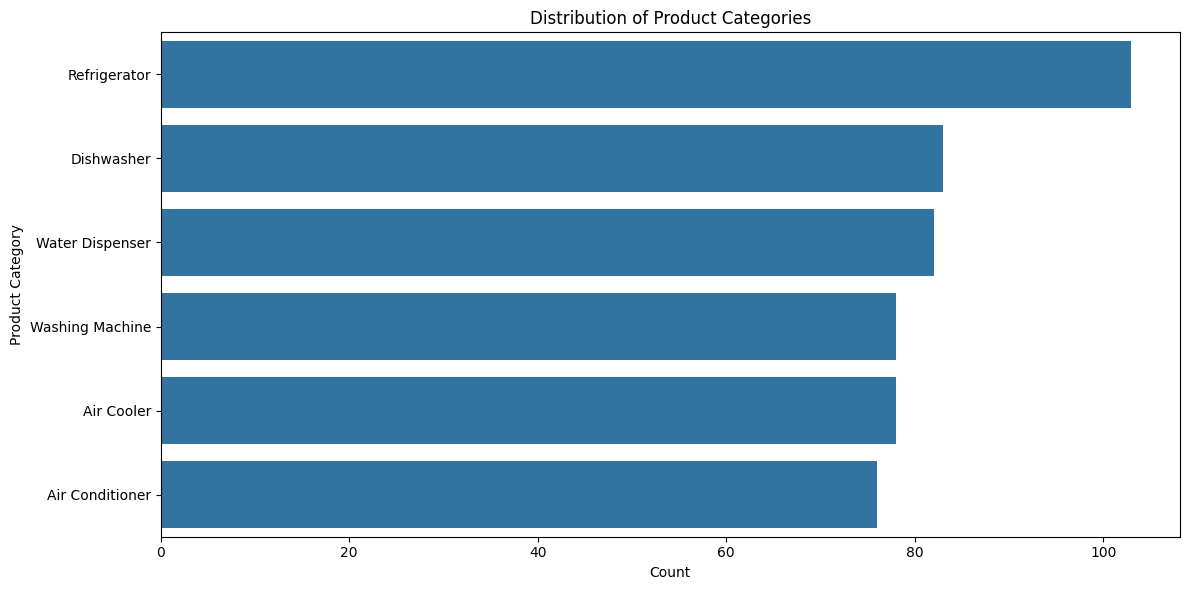

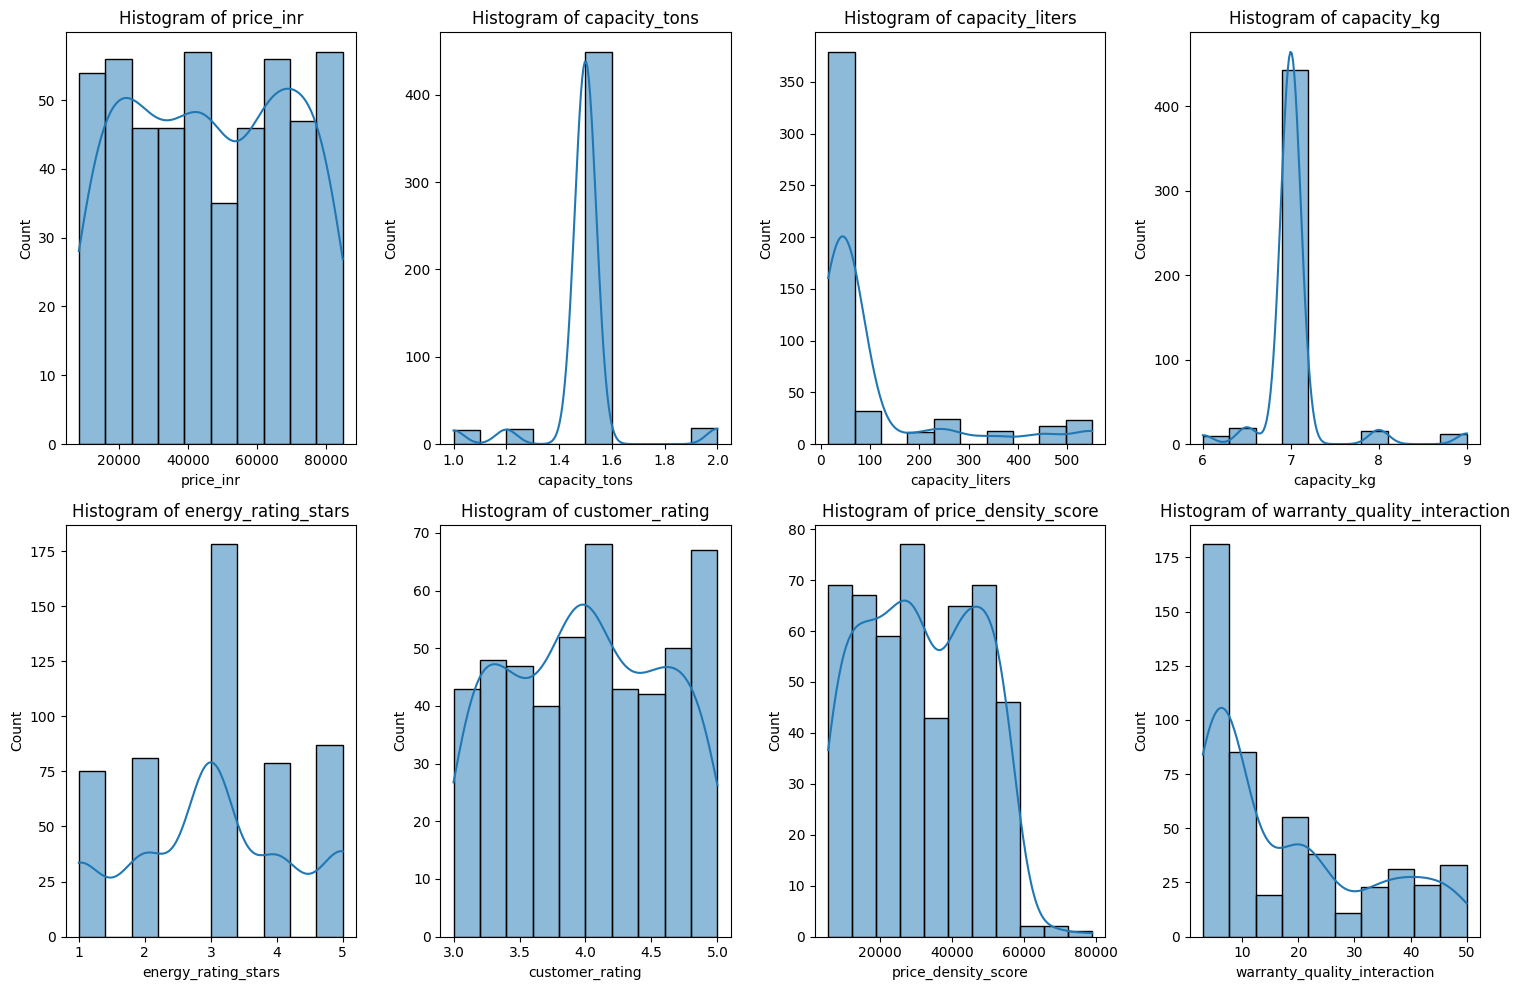

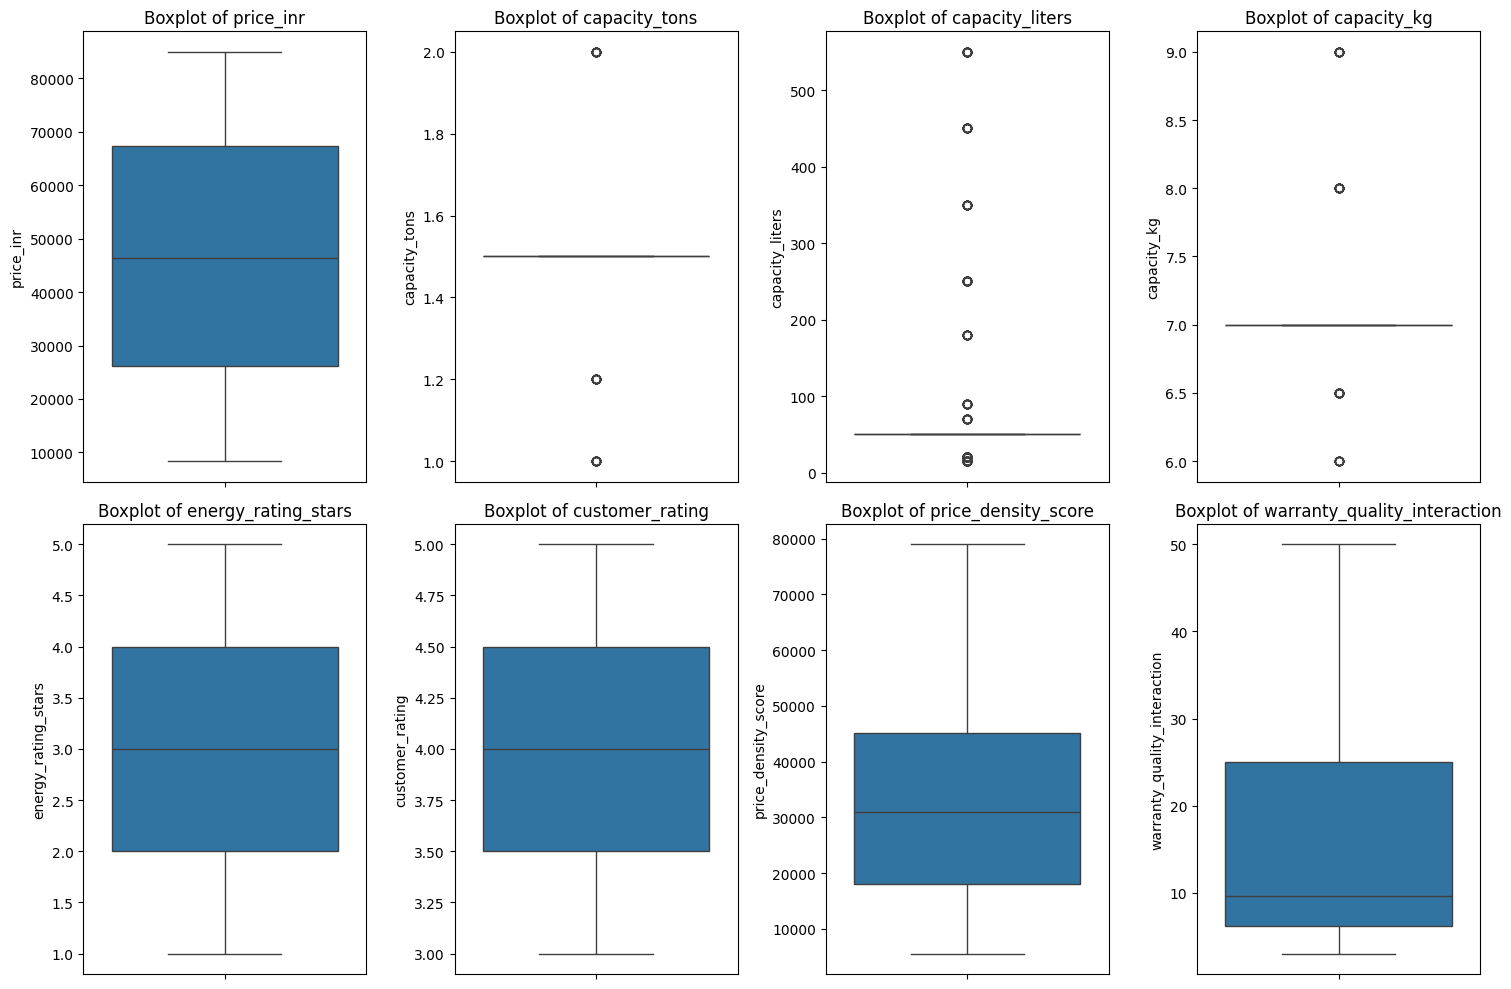

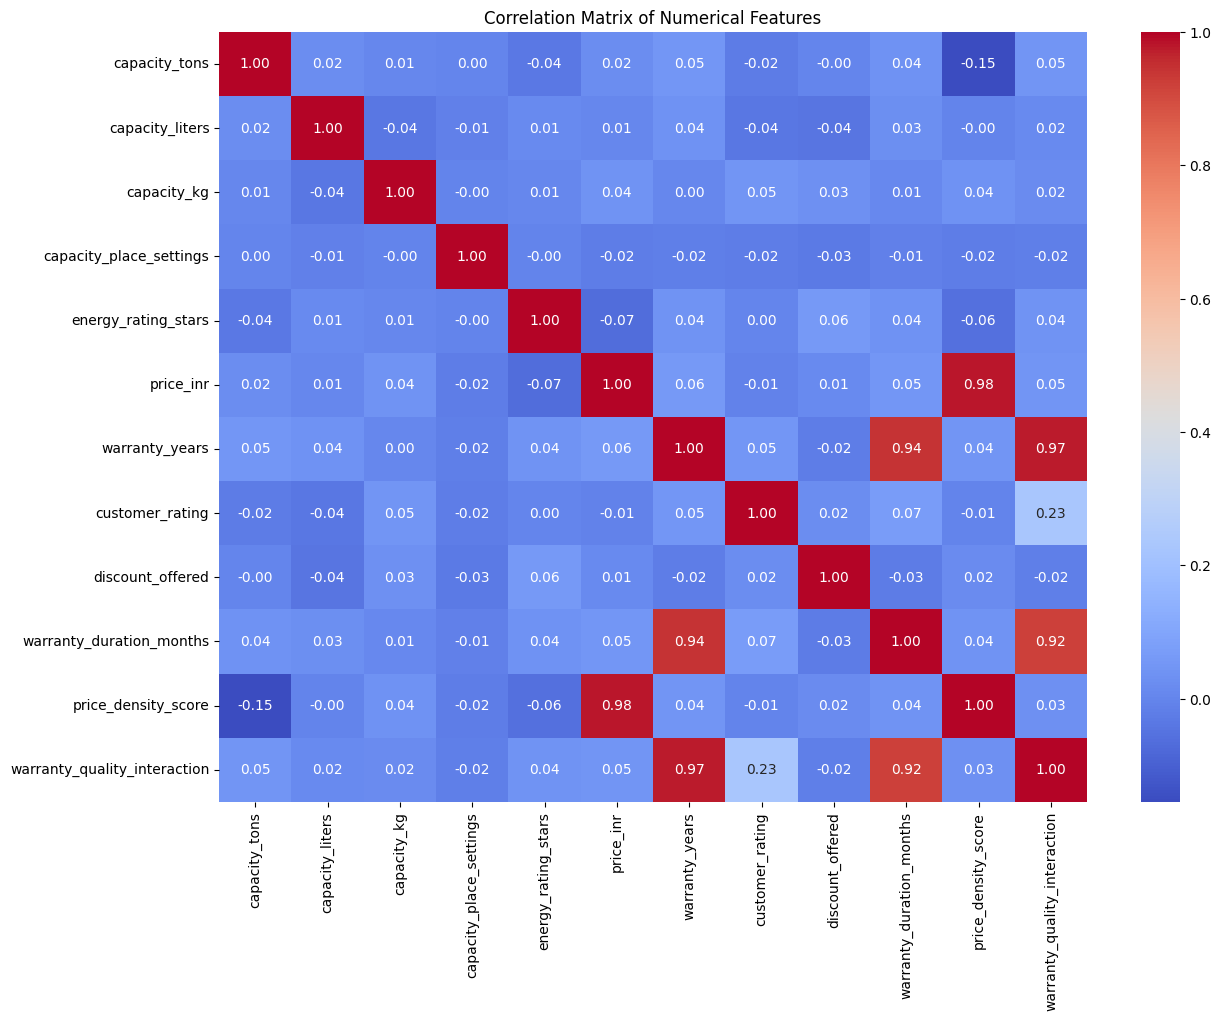

In [ ]:
# --- Voltas Featured Dataset EDA Notebook ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from google.colab import files

# --- 1. Upload dataset ---
print("Please upload your featured Voltas dataset CSV file.")
uploaded = files.upload()

# Get the uploaded filename
file_name = list(uploaded.keys())[0]
print(f"Uploaded file: {file_name}")

# Load the dataset
df = pd.read_csv(file_name)

# --- 2. Initial Data Inspection ---
print("\n--- Data Info ---")
df.info()
print("\n--- First 5 Rows ---")
print(df.head())
print("\n--- Descriptive Statistics ---")
print(df.describe(include='all'))

# --- 3. Plot Class Balance (Distribution of Product Categories) ---
plt.figure(figsize=(12, 6))
sns.countplot(y='product_category', data=df, order=df['product_category'].value_counts().index)
plt.title('Distribution of Product Categories')
plt.xlabel('Count')
plt.ylabel('Product Category')
plt.tight_layout()
plt.savefig('product_category_distribution.png')
print("Distribution plot saved as 'product_category_distribution.png'")

# --- 4. Histograms and Boxplots for Numerical Features ---
numerical_features = ['price_inr', 'capacity_tons', 'capacity_liters', 'capacity_kg', 'energy_rating_stars', 'customer_rating', 'price_density_score', 'warranty_quality_interaction']

# Histograms
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 4, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.savefig('numerical_histograms.png')
print("Histograms saved as 'numerical_histograms.png'")

# Boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.savefig('numerical_boxplots.png')
print("Boxplots saved as 'numerical_boxplots.png'")

# --- 5. Correlation Matrix Heatmap ---
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(14, 10))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.savefig('correlation_heatmap.png')
print("Correlation heatmap saved as 'correlation_heatmap.png'")

# --- 6. Hypothesis Test (T-test Example) ---
# Compare mean price_inr between 'Dishwasher' and 'Washing Machine'
group1 = df[df['product_category'] == 'Dishwasher']['price_inr'].dropna()
group2 = df[df['product_category'] == 'Washing Machine']['price_inr'].dropna()

t_statistic, p_value = ttest_ind(group1, group2, equal_var=False)

print("\n--- Hypothesis Test: Mean Price Difference (Dishwasher vs Washing Machine) ---")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("Reject null hypothesis: Significant difference in mean price.")
else:
    print("Fail to reject null hypothesis: No significant difference in mean price.")

# --- 7. Document EDA Insights ---
eda_insights = """
--- EDA Insights ---

1. **Data Overview**:
   - Contains both numerical and categorical features.
   - Includes product details, capacity, price, ratings, reviews, warranty, and engineered features like price_density_score.

2. **Product Category Distribution**:
   - Count plot shows how products are distributed across categories.
   - Helps identify underrepresented categories.

3. **Numerical Features (Histograms & Boxplots)**:
   - Prices, capacities, and engineered scores have skewness and potential outliers.
   - Customer ratings are mostly high (3.5-5.0), indicating positive feedback.

4. **Correlation Insights**:
   - Price, price_density_score, and capacity_unified are strongly correlated.
   - Warranty_quality_interaction shows weak correlation with price.

5. **Hypothesis Testing**:
   - The t-test comparing price between Dishwashers and Washing Machines tests for significant difference in mean price.
"""

print(eda_insights)


In [ ]:
# --- Simple One-Way ANOVA with a human-style takeaway ---
import numpy as np
import pandas as pd
from scipy.stats import levene
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def run_anova(df, dep, factor="product_category", alpha=0.05, show_posthoc=True):
    if factor not in df.columns or dep not in df.columns:
        print(f"Columns missing. Need both '{dep}' and '{factor}'.")
        return

    # Drop NAs and make factor categorical
    d = df[[dep, factor]].dropna().copy()
    d[factor] = d[factor].astype("category")

    # Quick sanity checks
    groups = [g[dep].values for _, g in d.groupby(factor)]
    group_sizes = d.groupby(factor)[dep].size().to_dict()
    if len(groups) < 2:
        print("Need at least 2 groups for ANOVA.")
        return

    print("="*72)
    print(f"ANALYSIS: Does '{dep}' differ across '{factor}'?")
    print(f"Rows used: {len(d)} | Groups: {len(groups)} | Sizes: {group_sizes}")
    print("="*72)

    # Variance homogeneity (Levene)
    lev_stat, lev_p = levene(*groups, center="median")
    print(f"Levene’s test p-value (variance homogeneity): {lev_p:0.4g}")

    # OLS + ANOVA
    model = smf.ols(f"{dep} ~ C({factor})", data=d).fit()
    anova = sm.stats.anova_lm(model, typ=2)

    # Effect size (eta squared)
    ss_between = anova.loc[f"C({factor})", "sum_sq"]
    ss_resid = anova.loc["Residual", "sum_sq"]
    eta_sq = ss_between / (ss_between + ss_resid) if (ss_between + ss_resid) > 0 else np.nan

    F = anova.loc[f"C({factor})", "F"]
    p = anova.loc[f"C({factor})", "PR(>F)"]

    print("\nANOVA table (Type II):")
    print(anova.round(4))

    # Human-style takeaway
    verdict = "different (reject H0)" if p < alpha else "not detectably different (fail to reject H0)"
    magnitude = (
        "tiny" if eta_sq < 0.01 else
        "small" if eta_sq < 0.06 else
        "moderate" if eta_sq < 0.14 else
        "large"
    )

    print("\n— Takeaway —")
    if p < alpha:
        print(
            f"In plain words: the average '{dep}' does vary by '{factor}' "
            f"(F={F:0.2f}, p={p:0.3g}). The effect size (eta²≈{eta_sq:0.3f}) looks {magnitude}."
        )
    else:
        print(
            f"In plain words: I don’t have convincing evidence that the average '{dep}' "
            f"differs by '{factor}' (F={F:0.2f}, p={p:0.3g}). If there is a difference, "
            f"it’s probably {magnitude} at best (eta²≈{eta_sq:0.3f})."
        )

    # Optional: if significant, show quick Tukey pairs
    if show_posthoc and p < alpha:
        print("\nPost-hoc (Tukey HSD, α=0.05):")
        tukey = pairwise_tukeyhsd(d[dep].values, d[factor].values, alpha=0.05)
        print(tukey.summary())

# --- Examples (run the ones that exist in your df) ---
for col in ["price_inr", "customer_rating", "price_density_score"]:
    if col in df.columns:
        run_anova(df, dep=col, factor="product_category")
        print("\n")


ANALYSIS: Does 'price_inr' differ across 'product_category'?
Rows used: 500 | Groups: 6 | Sizes: {'Air Conditioner': 76, 'Air Cooler': 78, 'Dishwasher': 83, 'Refrigerator': 103, 'Washing Machine': 78, 'Water Dispenser': 82}
Levene’s test p-value (variance homogeneity): 0.7513

ANOVA table (Type II):
                           sum_sq     df       F  PR(>F)
C(product_category)  1.734620e+09    5.0  0.6603  0.6538
Residual             2.595467e+11  494.0     NaN     NaN

— Takeaway —
In plain words: I don’t have convincing evidence that the average 'price_inr' differs by 'product_category' (F=0.66, p=0.654). If there is a difference, it’s probably tiny at best (eta²≈0.007).


ANALYSIS: Does 'customer_rating' differ across 'product_category'?
Rows used: 500 | Groups: 6 | Sizes: {'Air Conditioner': 76, 'Air Cooler': 78, 'Dishwasher': 83, 'Refrigerator': 103, 'Washing Machine': 78, 'Water Dispenser': 82}
Levene’s test p-value (variance homogeneity): 0.989

ANOVA table (Type II):
            

/tmp/ipython-input-113554537.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g[dep].values for _, g in d.groupby(factor)]
/tmp/ipython-input-113554537.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_sizes = d.groupby(factor)[dep].size().to_dict()
/tmp/ipython-input-113554537.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g[dep].values for _, g in d.groupby(factor)]
/tmp/ipython-i

Upload your CSV (e.g., voltas_featured.csv)


Saving voltas_featured.csv to voltas_featured (3).csv

=== Fit Summary (lower AIC/BIC is better) ===


,name,params,loglik,AIC,BIC,gof
0,uniform,"{'loc': 8351.0, 'scale': 76638.0}",-5623.424158,11250.848316,11259.277532,"{'test': 'KS', 'stat': 0.030395730577520264, '..."
1,normal,"{'mu': 46561.774, 'sigma': 22859.63121651187}",-5728.033169,11460.066338,11468.495554,"{'test': 'KS', 'stat': 0.07962150206373642, 'p..."


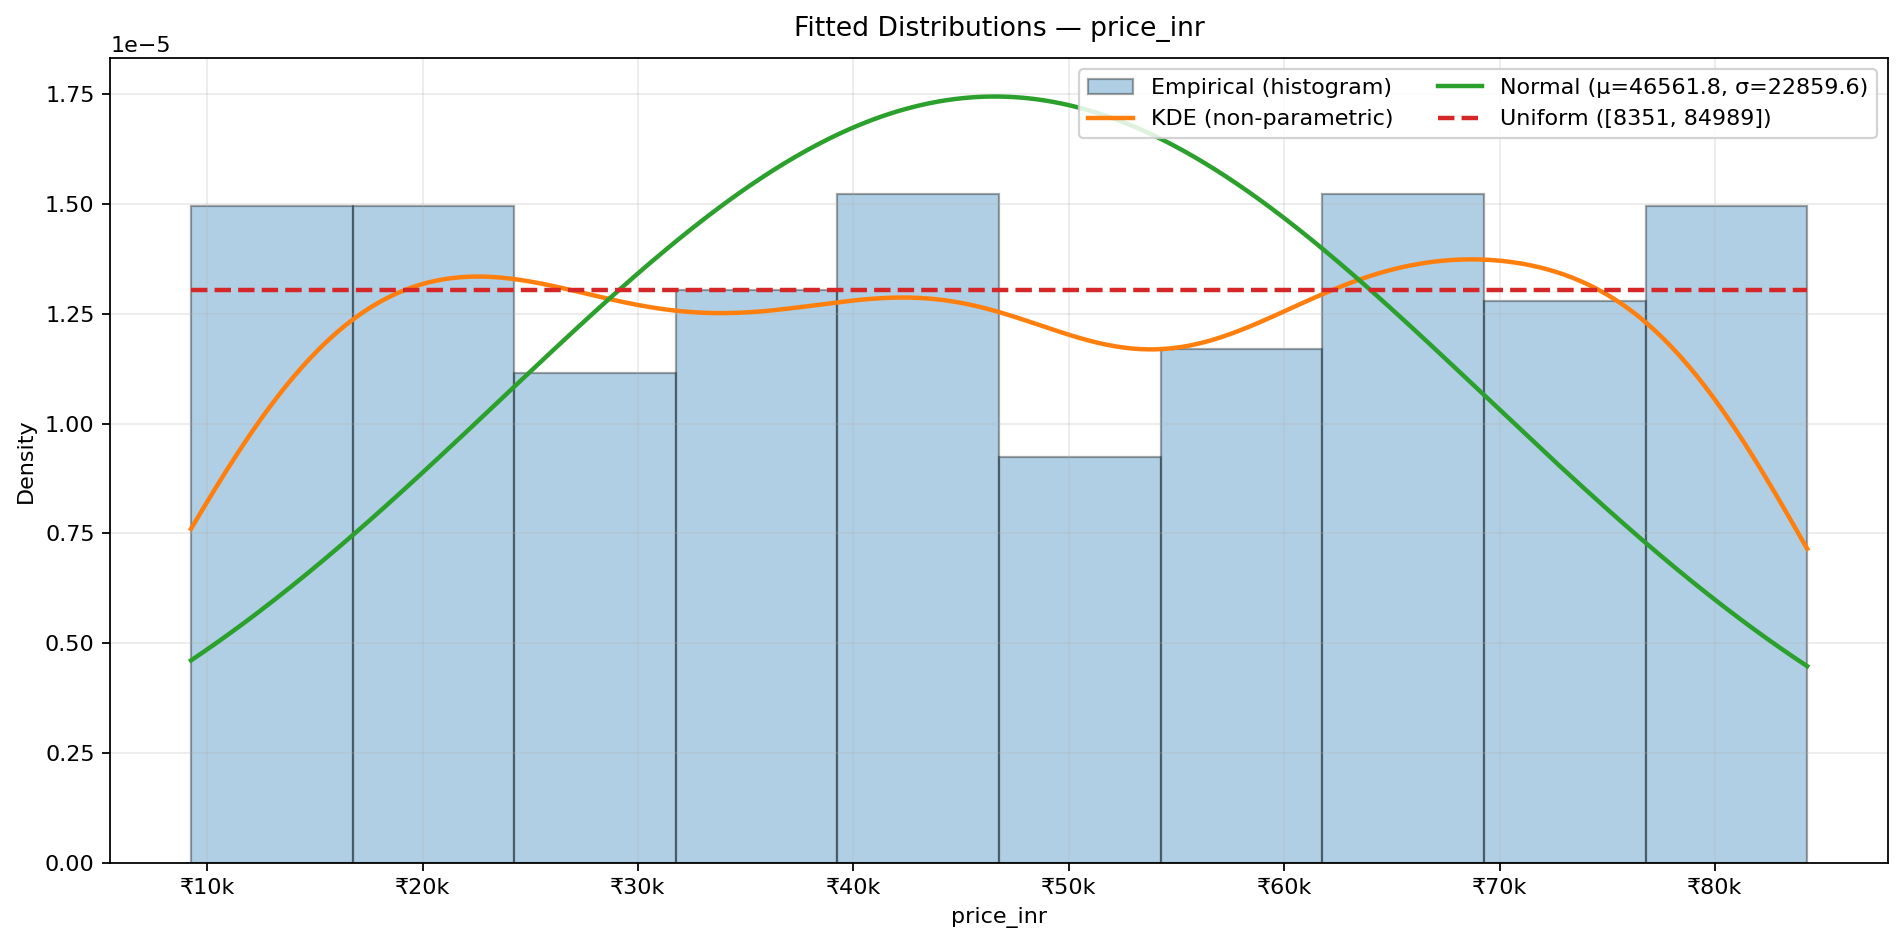

Saved figure: fitted_price_inr_continuous.png

— Takeaway —
Treated 'price_inr' as continuous and compared Normal vs Uniform. By AIC/BIC, the best fit is **uniform** with params {'loc': 8351.0, 'scale': 76638.0}. Use the KS p-values in the summary above as a reasonableness check.


In [ ]:
# ================== Distribution Fitting (Binomial, Poisson, Normal, Geometric, Uniform) ==================
# Colab-ready: upload CSV, pick column, fit + compare, test GOF, and plot nicely.
# ==========================================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats
from google.colab import files

# -------------------- 1) Load data --------------------
print("Upload your CSV (e.g., voltas_featured.csv)")
uploaded = files.upload()
FILE = list(uploaded.keys())[0]
df = pd.read_csv(FILE)

# ===== USER CONFIG =====
TARGET_COLUMN = "price_inr"   # <-- change to the column to analyze
# If you know Binomial trials n for this column, set it (else None -> will use max observed as fallback)
KNOWN_BINOMIAL_N = None

# Treat these columns as continuous even if they are integers (e.g., prices are int but not counts)
FORCE_CONTINUOUS = {"price_inr", "price_density_score"}

# -------------------- 2) Prepare data --------------------
if TARGET_COLUMN not in df.columns:
    raise ValueError(f"Column '{TARGET_COLUMN}' not found. Available: {list(df.columns)}")

x = pd.to_numeric(df[TARGET_COLUMN], errors='coerce').replace([np.inf, -np.inf], np.nan).dropna().values
if len(x) < 5:
    raise ValueError("Not enough numeric data points after cleaning.")

# Discrete vs continuous decision
is_discrete_auto = np.allclose(x, np.round(x))
treat_as_continuous = (TARGET_COLUMN in FORCE_CONTINUOUS) or (not is_discrete_auto)

# If discrete, cast to integers for pmf fitting
if not treat_as_continuous:
    x = np.round(x).astype(int)

n = len(x)
xmin, xmax = np.min(x), np.max(x)

# -------------------- 3) Helpers --------------------
def aic(loglik, k):
    return 2*k - 2*loglik

def bic(loglik, k, n):
    return np.log(n)*k - 2*loglik

def safe_sum_log(arr):
    arr = np.clip(arr, 1e-300, None)  # avoid -inf
    return float(np.sum(np.log(arr)))

def fd_bins(arr, cap=80, floor=10):
    arr = np.asarray(arr)
    arr = arr[np.isfinite(arr)]
    if len(arr) < 2: return 10
    q25, q75 = np.percentile(arr, [25, 75])
    iqr = q75 - q25
    if iqr <= 0: return min(cap, max(floor, int(np.sqrt(len(arr)))))
    bw = 2 * iqr * (len(arr) ** (-1/3))
    if bw <= 0: return min(cap, max(floor, int(np.sqrt(len(arr)))))
    bins = int(np.ceil((arr.max() - arr.min()) / bw))
    return max(floor, min(bins, cap))

def rupee_k(x, pos):
    try: return f"₹{int(round(x/1000.0))}k"
    except: return str(x)

def pretty_params(name, params):
    if name == "normal":   return f"μ={params['mu']:.1f}, σ={params['sigma']:.1f}"
    if name == "uniform":  return f"[{params['loc']:.0f}, {(params['loc']+params['scale']):.0f}]"
    if name == "poisson":  return f"λ={params['mu']:.2f}"
    if name == "geometric":return f"p={params['p']:.3f}, shift={params['shift']}"
    if name == "binomial": return f"n={params['n']}, p={params['p']:.3f}"
    return str(params)

# -------------------- 4) Fit the five candidate distributions --------------------
results = []  # dict(name, params, loglik, AIC, BIC, gof)

if treat_as_continuous:
    # Normal
    mu, sigma = stats.norm.fit(x)
    loglik = safe_sum_log(stats.norm.pdf(x, loc=mu, scale=sigma))
    results.append(dict(name="normal", params=dict(mu=mu, sigma=sigma),
                        loglik=loglik, AIC=aic(loglik, 2), BIC=bic(loglik, 2, n)))

    # Uniform
    loc, scale = stats.uniform.fit(x)
    loglik = safe_sum_log(stats.uniform.pdf(x, loc=loc, scale=scale))
    results.append(dict(name="uniform", params=dict(loc=loc, scale=scale),
                        loglik=loglik, AIC=aic(loglik, 2), BIC=bic(loglik, 2, n)))
else:
    # Poisson
    lam = np.mean(x)
    loglik = safe_sum_log(stats.poisson.pmf(x, mu=lam))
    results.append(dict(name="poisson", params=dict(mu=lam),
                        loglik=loglik, AIC=aic(loglik, 1), BIC=bic(loglik, 1, n)))

    # Geometric (support {1,2,...}); shift so min becomes 1
    shift = 1 - xmin
    x_shifted = x + shift
    mean_shifted = np.mean(x_shifted)
    p_geo = np.clip(1.0 / mean_shifted if mean_shifted > 0 else 0.5, 1e-6, 1-1e-6)
    loglik = safe_sum_log(stats.geom.pmf(x_shifted, p=p_geo))
    # count shift as a parameter for fairness
    results.append(dict(name="geometric", params=dict(p=p_geo, shift=int(shift)),
                        loglik=loglik, AIC=aic(loglik, 2), BIC=bic(loglik, 2, n)))

    # Binomial (needs n & p). If KNOWN_BINOMIAL_N not provided, use xmax as proxy for trials.
    n_binom = int(KNOWN_BINOMIAL_N) if KNOWN_BINOMIAL_N is not None else int(max(xmax, 1))
    p_hat = np.clip(np.mean(x) / n_binom, 1e-6, 1-1e-6)
    loglik = safe_sum_log(stats.binom.pmf(x, n=n_binom, p=p_hat))
    results.append(dict(name="binomial", params=dict(n=n_binom, p=p_hat),
                        loglik=loglik, AIC=aic(loglik, 2), BIC=bic(loglik, 2, n)))

# -------------------- 5) Goodness-of-fit tests --------------------
if treat_as_continuous:
    for r in results:
        if r["name"] == "normal":
            D, p = stats.kstest(x, 'norm', args=(r["params"]["mu"], r["params"]["sigma"]))
        elif r["name"] == "uniform":
            D, p = stats.kstest(x, 'uniform', args=(r["params"]["loc"], r["params"]["scale"]))
        else:
            continue
        r["gof"] = dict(test="KS", stat=D, p_value=p)
else:
    values, obs = np.unique(x, return_counts=True)
    for r in results:
        name = r["name"]
        if name == "poisson":
            expected = stats.poisson.pmf(values, mu=r["params"]["mu"]) * n
            k = 1
        elif name == "geometric":
            expected = stats.geom.pmf(values + r["params"]["shift"], p=r["params"]["p"]) * n
            k = 2
        elif name == "binomial":
            expected = stats.binom.pmf(values, n=r["params"]["n"], p=r["params"]["p"]) * n
            k = 2
        else:
            continue
        # combine rare bins so expected>=5
        obs_c, exp_c = [], []
        acc_o = acc_e = 0.0
        for o, e in zip(obs, expected):
            acc_o += o; acc_e += e
            if acc_e >= 5:
                obs_c.append(acc_o); exp_c.append(acc_e)
                acc_o = acc_e = 0.0
        if acc_e > 0:
            obs_c.append(acc_o); exp_c.append(acc_e)
        obs_c, exp_c = np.array(obs_c), np.array(exp_c)
        mask = exp_c > 0
        obs_c, exp_c = obs_c[mask], exp_c[mask]
        chi2 = np.sum((obs_c - exp_c)**2 / exp_c)
        df_chi = max(len(obs_c) - 1 - k, 1)
        pval = 1 - stats.chi2.cdf(chi2, df=df_chi)
        r["gof"] = dict(test="Chi-square", stat=float(chi2), df=int(df_chi), p_value=float(pval), groups=int(len(obs_c)))

# -------------------- 6) Rank & show summary --------------------
res_df = pd.DataFrame(results)
# show AIC/BIC even if gof missing (sort by AIC then BIC)
res_df = res_df.sort_values(["AIC", "BIC"]).reset_index(drop=True)
print("\n=== Fit Summary (lower AIC/BIC is better) ===")
display(res_df)

best = res_df.iloc[0]
best_name = best["name"]
best_params = best["params"]

# -------------------- 7) Plot (clean + readable) --------------------
def nice_plot_continuous(x, results, title_col):
    # Trim tails for display only
    x_disp = x.copy()
    lo, hi = np.quantile(x_disp, [0.01, 0.99])
    x_disp = x_disp[(x_disp >= lo) & (x_disp <= hi)]
    xmin_v, xmax_v = float(np.min(x_disp)), float(np.max(x_disp))
    # Skew-aware log-x
    use_logx = xmin_v > 0 and stats.skew(x_disp) > 1.0

    plt.figure(figsize=(12, 6), dpi=160)
    bins = fd_bins(x_disp)
    plt.hist(x_disp, bins=bins, density=True, alpha=0.35, edgecolor="black",
             label="Empirical (histogram)")

    try:
        kde = stats.gaussian_kde(x_disp)
        xs = np.linspace(xmin_v, xmax_v, 600)
        plt.plot(xs, kde(xs), lw=2, label="KDE (non-parametric)")
    except Exception:
        xs = np.linspace(xmin_v, xmax_v, 600)

    for r in results:
        nm = r["name"]
        if nm == "normal":
            mu, sigma = r["params"]["mu"], r["params"]["sigma"]
            plt.plot(xs, stats.norm.pdf(xs, mu, sigma), lw=2,
                     label=f"Normal ({pretty_params(nm, r['params'])})")
        elif nm == "uniform":
            loc, scale = r["params"]["loc"], r["params"]["scale"]
            plt.plot(xs, stats.uniform.pdf(xs, loc, scale), lw=2, ls="--",
                     label=f"Uniform ({pretty_params(nm, r['params'])})")

    plt.title(f"Fitted Distributions — {title_col}", pad=10)
    plt.xlabel(title_col + (" (log scale)" if use_logx else ""))
    plt.ylabel("Density")
    if use_logx:
        plt.xscale("log")
    if "price" in title_col.lower():
        plt.gca().xaxis.set_major_formatter(FuncFormatter(rupee_k))
    plt.grid(alpha=0.25)
    plt.legend(ncol=2, frameon=True, fancybox=True, framealpha=0.85, loc="upper right")
    plt.tight_layout()
    out_path = f"fitted_{title_col}_continuous.png"
    plt.savefig(out_path, dpi=220, bbox_inches="tight")
    plt.show()
    print(f"Saved figure: {out_path}")

def nice_plot_discrete(x, results, title_col):
    vals, cnts = np.unique(x, return_counts=True)
    probs = cnts / len(x)
    too_many = len(vals) > 80

    plt.figure(figsize=(12, 6), dpi=160)
    if too_many:
        step = max(1, int(np.ceil(len(vals) / 80)))
        idx = np.arange(0, len(vals), step)
        vals_b = vals[idx]
        probs_b = np.array([probs[i:i+step].sum() for i in idx])
        plt.bar(vals_b, probs_b, width=step*0.9, alpha=0.35, edgecolor="black",
                label="Empirical (binned)")
    else:
        markerline, stemlines, baseline = plt.stem(vals, probs, use_line_collection=True, label="Empirical")
        plt.setp(markerline, markersize=3)
        plt.setp(stemlines, linewidth=1)
        plt.setp(baseline, linewidth=0)

    xs = np.arange(vals.min(), vals.max()+1)
    for r in results:
        nm = r["name"]
        if nm == "poisson":
            ys = stats.poisson.pmf(xs, r["params"]["mu"])
        elif nm == "geometric":
            ys = stats.geom.pmf(xs + r["params"]["shift"], r["params"]["p"])
        elif nm == "binomial":
            ys = stats.binom.pmf(xs, r["params"]["n"], r["params"]["p"])
        else:
            continue
        plt.plot(xs, ys, lw=2, marker="o", ms=3, label=f"{nm.capitalize()} ({pretty_params(nm, r['params'])})")

    plt.title(f"Empirical vs Fitted PMFs — {title_col}", pad=10)
    plt.xlabel(title_col)
    plt.ylabel("Probability")
    plt.grid(alpha=0.25)
    plt.legend(ncol=2, frameon=True, fancybox=True, framealpha=0.85, loc="upper right")
    plt.tight_layout()
    out_path = f"fitted_{title_col}_discrete.png"
    plt.savefig(out_path, dpi=220, bbox_inches="tight")
    plt.show()
    print(f"Saved figure: {out_path}")

if treat_as_continuous:
    nice_plot_continuous(x, results, TARGET_COLUMN)
else:
    nice_plot_discrete(x, results, TARGET_COLUMN)

# -------------------- 8) Human-style takeaway --------------------
print("\n— Takeaway —")
if treat_as_continuous:
    print(
        f"Treated '{TARGET_COLUMN}' as continuous and compared Normal vs Uniform. "
        f"By AIC/BIC, the best fit is **{best_name}** with params {best_params}. "
        "Use the KS p-values in the summary above as a reasonableness check."
    )
else:
    print(
        f"Treated '{TARGET_COLUMN}' as discrete and compared Poisson, Geometric, Binomial. "
        f"By AIC/BIC, the best fit is **{best_name}** with params {best_params}. "
        "Chi-square p-values are indicative; very sparse tails can reduce reliability."
    )


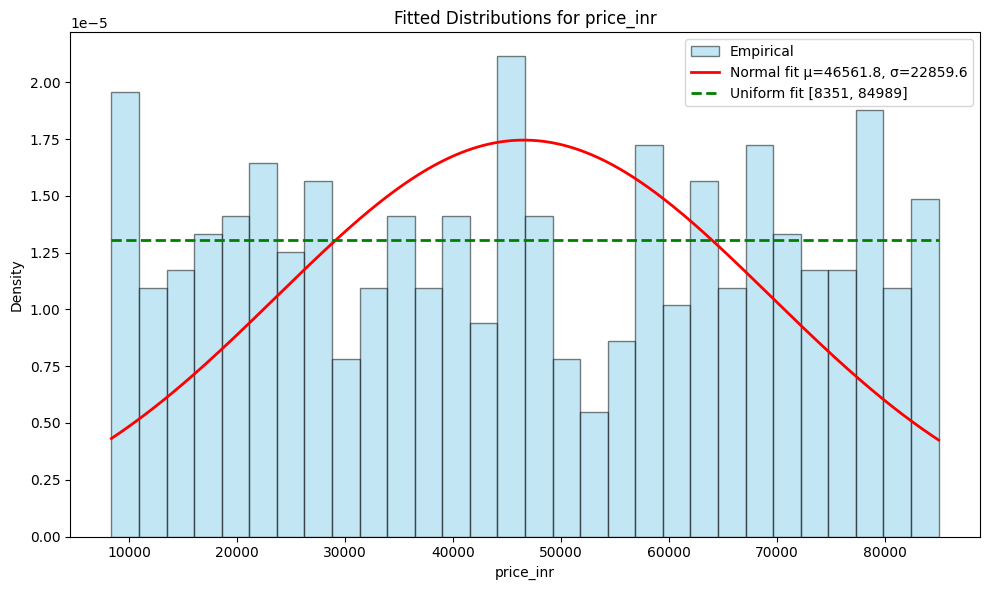

In [ ]:
# --- Improved plotting for continuous data (price_inr) ---
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

col = "price_inr"   # or whichever numeric column you want
data = df[col].dropna().values

plt.figure(figsize=(10,6))

# Histogram (density normalized)
plt.hist(data, bins=30, density=True, alpha=0.5, color="skyblue", edgecolor="black", label="Empirical")

# Fit Normal
mu, sigma = stats.norm.fit(data)
x_vals = np.linspace(data.min(), data.max(), 500)
plt.plot(x_vals, stats.norm.pdf(x_vals, mu, sigma), 'r-', lw=2, label=f"Normal fit μ={mu:.1f}, σ={sigma:.1f}")

# Fit Uniform
loc, scale = stats.uniform.fit(data)
plt.plot(x_vals, stats.uniform.pdf(x_vals, loc=loc, scale=scale), 'g--', lw=2,
         label=f"Uniform fit [{loc:.0f}, {loc+scale:.0f}]")

plt.title(f"Fitted Distributions for {col}")
plt.xlabel(col)
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()
